In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn import svm

DATA_DIR = './data/'
DATA_FILE = './adult.data'
TEST_FILE = './adult.test'
NAMES = ['age', 'workclass','fnlwgt','education','education-num','marital-status',
         'occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','income']

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def logistic_prediction(theta, X):
    h = np.dot(X, theta)
    return sigmoid(h)


def logistic_regression_cost_grad(features, target, theta, regu=0):
    #TODO: add regularisation
    # Theta is a column vector of dim (n)
    # features is a dim (m x n) matrix
    # target is a column vector of dim (m)
    m = len(features)
    h = logistic_prediction(theta, features)
    # Cost
    J = -(1/m) * (np.dot(np.log(h).T, target) + np.dot(np.log(1-h).T, (1-target)))
    # Gradient
    grad = np.dot(features.T,(h-target))/m
    return float(J), grad


def preprocess_data(data_df, feature_list=None, mean=None, std=None):
    d = {}
    
    # Number of samples
    d['num_samples'] = len(data_df)
    
    # Replace '?' with NaN
    data_df = data_df.replace(' ?', np.nan)
    
    # Find how many rows have missing values, indicated by a '?'
    element_idx_missing_data = data_df.isnull()
    row_idx_missing_data = element_idx_missing_data.any(axis=1)
    num_samples_missing_data = sum(row_idx_missing_data)
    d['num_samples_missing_data'] = num_samples_missing_data
    
    # Remove samples with missing data
    data_df = data_df.dropna()
    
    # We can remove the eduction column as this is already nicely encoded
    # numerically in the education-num column.
    data_df = data_df.drop('education', axis=1)
    
    # Now we need to deal with the other categorical features which aren't
    # easily encoded as numerical values. We choose to use one-hot encoding,
    # because it will avoid any "confusion" that the algorithm may have
    # with numerical encodings of categories. The one-hot encoding will
    # effectively "unroll" all of the categorical features into unique features
    # corresponding to their possible values. For example the 'sex' feature
    # can take values 'Male' and 'Female'. This feature will become a 2D vector
    # ['sex_Male', 'sex_Female']; a feature [0, 1] denotes a 'Female' sample.
    # We want to get one-hot vectors for: sex, workclass, marital-status, occupation,
    # relationship, race, native-country, income.
    # Use a funky separator ('$_$') to be able to pick out the one-hot values later.
    dummy_cols = ['sex','workclass', 'marital-status', 'occupation', 'relationship', 'race', 'native-country', 'income']
    data_df = pd.get_dummies(data_df,columns=dummy_cols, prefix_sep='$_$')
    
    # Extract the target vector: income. We previously transformed this into a one-hot,
    # however we want this to be a binary scalar. The one-hot transformation will
    # help us to easily make a binary value using boolean operators.
    # Income <= 50K -> 0, income > 50K -> 1.
    try:
        data_df.rename(columns = {'income$_$ >50K.':'income$_$ >50K'}, inplace = True)
        data_df.rename(columns = {'income$_$ <=50K.':'income$_$ <=50K'}, inplace = True)
    except:
        pass
    target = data_df['income$_$ >50K']
    
    # Now drop the income vectors from the data frame to leave us with just the 
    # features.
    data_df = data_df.drop(['income$_$ <=50K', 'income$_$ >50K'], axis=1)
    
    d['feature_list'] = list(data_df)
    
    if feature_list is not None:
        # If there features are missing, add them
        for x in feature_list:
            if x not in list(data_df):
                data_df[x] = pd.Series([0 for _ in range(len(data_df))])
        for x in list(data_df):
            if x not in feature_list:
                data_df.drop(x)
        # Rearrange to ensure that the features are in the same order
        data_df = data_df[feature_list]

    # Since the data is a collection of one-hots and continuous values of different
    # ranges, let's do some normalisation and scaling.
    # We'll try two different normalisation schemes: normalise everything, and
    # only normalise continuous (non-one-hot) values.=
    data_mean = data_df.mean() if (mean is None) else mean
    data_std = data_df.std() if (std is None) else std
    data_df_norm_all = data_df - data_mean
    data_df_norm_all = data_df_norm_all / data_std
    d['mean'] = data_mean
    d['std'] = data_std
    # Do the continuous columns in a dumb way
    #non_oh_cols = [x for x in list(data_df) if '$_$' not in x]
    #data_df_norm_cont = data_df.copy()
    #for col in  non_oh_cols:
    #    data_df_norm_cont[col] = data_df[col] - data_df[col].mean()
    #    data_df_norm_cont[col] = data_df_norm_cont[col] / data_df[col].std()
        
    # We now have two normalised feature sets. Let's do some training.
    # First extend the features to have a column of 1s (bias) in the first column
    #data_df_norm_all.insert(0, 'bias', [1 for _ in range(len(data_df_norm_all))])
    #data_df_norm_cont.insert(0, 'bias', [1 for _ in range(len(data_df_norm_cont))])
    
    # Make features matrix
    features = data_df_norm_all.as_matrix()
    target = np.array(target, ndmin=2).T
    d['features'] = features
    d['target'] = target
    
    return d

In [ ]:
# Read the data in from the "adult" dataset
train_df = pd.read_csv(DATA_DIR + DATA_FILE, names=NAMES)
test_df = pd.read_csv(DATA_DIR + TEST_FILE, names=NAMES, skiprows=1)

training_data_dict = preprocess_data(train_df)
test_data_dict = preprocess_data(test_df,
                                 feature_list=training_data_dict['feature_list'],
                                 mean=training_data_dict['mean'],
                                 std=training_data_dict['std'])

# Create some parameter vectors for each feature set. Initialise to 0
num_features = training_data_dict['features'].shape[1]
theta = np.zeros((num_features, 1))

# Train
train_features = training_data_dict['features']
train_target = training_data_dict['target']

test_features = test_data_dict['features']
test_target = test_data_dict['target']

alpha = 0.03
num_iterations = 10000
Jtrain_array = []
Jtest_array = []
for iteration in range(num_iterations):
    J, grad = logistic_regression_cost_grad(test_features, test_target, theta)
    Jtest_array.append(J)
    J, grad = logistic_regression_cost_grad(train_features, train_target, theta)
    Jtrain_array.append(J)
    
    # Update parameters
    theta = theta - alpha * grad
    
    if (iteration % 500 == 0):
        print(iteration, 'of', num_iterations, flush=True)


In [ ]:
# Predict on training set
train_features = training_data_dict['features']
train_target = training_data_dict['target']
prediction = logistic_prediction(theta, train_features)
correct_training_predictions = np.logical_not(np.logical_xor(prediction > 0.5, train_target > 0.5))
train_result_df = pd.DataFrame()
train_result_df['predictions'] = pd.Series(prediction.flatten()>0.5)
train_result_df['target'] = pd.Series(train_target.flatten() > 0.5)
train_result_df['result'] = correct_training_predictions
print("Success rate on training data:", train_result_df.result.sum()/len(train_result_df))

# Predict on test set
test_features = test_data_dict['features']
test_target = test_data_dict['target']
prediction = logistic_prediction(theta, test_features)
correct_test_predictions = np.logical_not(np.logical_xor(prediction > 0.5, test_target > 0.5))
test_result_df = pd.DataFrame()
test_result_df['predictions'] = pd.Series(prediction.flatten()>0.5)
test_result_df['target'] = pd.Series(test_target.flatten() > 0.5)
test_result_df['result'] = correct_test_predictions
print("Success rate on test data:", test_result_df.result.sum()/len(test_result_df))

# Show predictors
s = pd.Series(theta[1:].flatten(), index=training_data_dict['feature_list'])
with pd.option_context('display.max_rows', None, 'display.max_columns', 3): display(s.sort_values(ascending=False))

# Plot
plt.plot(Jtrain_array)
plt.plot(Jtest_array)
plt.show()

In [ ]:
clf = sklearn.svm.SVC()
clf.fit(train_features, train_target.ravel())

In [ ]:
train_features = training_data_dict['features']
train_target = training_data_dict['target']
prediction = []
idx = []
for i, feature in enumerate(train_features):
    if np.isnan(feature).any():
        continue
    idx.append(i)
    prediction.append(clf.predict(feature.reshape(1, -1)))
correct_test_predictions = np.logical_not(np.logical_xor(np.array(prediction) > 0.5, train_target[idx] > 0.5))

In [ ]:
print("Success rate on test data:", correct_test_predictions.sum()/len(correct_test_predictions))

In [ ]:
# Predict on training set
#train_features = training_data_dict['features']
#train_target = training_data_dict['target']
#prediction = clf.predict(train_features)
#correct_training_predictions = np.logical_not(np.logical_xor(prediction > 0.5, train_target > 0.5))
#train_result_df = pd.DataFrame()
#train_result_df['predictions'] = pd.Series(prediction.flatten()>0.5)
#train_result_df['target'] = pd.Series(train_target.flatten() > 0.5)
#train_result_df['result'] = correct_training_predictions
#print("Success rate on training data:", train_result_df.result.sum()/len(train_result_df))

# Predict on test set
test_features = test_data_dict['features']
test_target = test_data_dict['target']
prediction = []
idx = []
for i, feature in enumerate(test_features):
    if np.isnan(feature).any():
        continue
    idx.append(i)
    prediction.append(clf.predict(feature.reshape(1, -1)))
correct_test_predictions = np.logical_not(np.logical_xor(np.array(prediction) > 0.5, test_target[idx] > 0.5))
#test_result_df = pd.DataFrame()
#test_result_df['predictions'] = pd.Series(prediction.flatten()>0.5)
#test_result_df['target'] = pd.Series(test_target.flatten() > 0.5)
#test_result_df['result'] = correct_test_predictions
#print("Success rate on test data:", test_result_df.result.sum()/len(test_result_df))


In [ ]:
print("Success rate on test data:", correct_test_predictions.sum()/len(correct_test_predictions))

In [2]:
import tensorflow as tf
from tensorflow.python import debug as tf_debug
from tqdm import tnrange, tqdm_notebook, tqdm

In [69]:
# TODO: Implement logistic regression with TF
class TFLogisticRegression():
    def __init__(self, num_features, num_classes):
        
        # Classifier graph
        self.input_node = tf.placeholder(dtype=tf.float32,
                          shape=[num_features, None],
                          name="feature_ph")
        self.weights = tf.Variable(dtype=tf.float32,
                           initial_value=tf.zeros([num_features, 1]),
                           trainable=True,
                           name="weights")
        self.bias = tf.Variable(dtype=tf.float32,
                                initial_value=tf.zeros([1]),
                                trainable=True,
                                name="bias")
        
        self.logits = tf.matmul(self.input_node,
                                self.weights,
                                transpose_a=True, 
                                name="logits") + self.bias
        self.prediction = tf.sigmoid(self.logits,
                                     name="prediction_op")
        
        # Learning graph
        self.target = tf.placeholder(dtype=tf.float32,
                                     shape=[None,num_classes],
                                     name="target_ph")
        self.cost = tf.losses.sigmoid_cross_entropy(self.target,
                                                    logits=self.logits)
        self.reg_lambda = tf.placeholder(dtype=tf.float32,
                                         name="lambda")
        self.cost = self.cost + self.reg_lambda * tf.nn.l2_loss(self.weights)
        self.learning_rate = tf.placeholder(dtype=tf.float32,
                                         name="learning_rate")
        self.update = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate)

        self.update = self.update.minimize(self.cost)

    def initialise_graph(self, sess):
        init = tf.global_variables_initializer()
        sess.run(init)
        
    def predict(self, sess, x):
        return sess.run(self.prediction,
                        feed_dict={self.input_node:x})
    
    
    def _train_step(self, sess, _x, _y, learning_rate, reg_lambda):
        feed_dict = {self.input_node: _x,
                     self.target: _y,
                     self.learning_rate: learning_rate,
                     self.reg_lambda: reg_lambda}
        cost, _ = sess.run([self.cost, self.update],
                           feed_dict=feed_dict)
        return cost
    
    def train(self, sess, x, y, learning_rate, reg_lambda, batch_size, num_epochs):
        num_batches = int(np.floor(x.shape[0]/batch_size))
        batch_remainder = x.shape[0] % batch_size
        cost_list = []
        for i in tqdm_notebook(range(num_epochs), desc='Training'):
            for j in range(num_batches):
                k = j * batch_size
                _x = np.matrix(x[k:k+batch_size-1]).T
                _y = np.matrix(y[k:k+batch_size-1])
                cost = self._train_step(sess, _x, _y, learning_rate, reg_lambda)
                cost_list.append(cost)
            if (batch_remainder > 0):
                # Do remainder
                k = -batch_remainder
                _x = np.matrix(x[k:]).T
                _y = np.matrix(y[k:])
                cost = self._train_step(sess, _x, _y, learning_rate, reg_lambda)
                cost_list.append(cost)
                
            if i % 250 == 0:
                p = self.predict(sess, x.T)
                pr = np.logical_not(np.logical_xor(p > 0.5, y > 0.5))
                #print(pr[:10])
                accuracy = pr.sum()/len(pr)
                tqdm.write("Iteration %i | Accuracy: %f | Cost: %f" % (i, accuracy, cost_list[-1]))

        return cost_list
        

train_df = pd.read_csv(DATA_DIR + DATA_FILE, names=NAMES)
test_df = pd.read_csv(DATA_DIR + TEST_FILE, names=NAMES, skiprows=1)

training_data_dict = preprocess_data(train_df)
test_data_dict = preprocess_data(test_df,
                                 feature_list=training_data_dict['feature_list'],
                                 mean=training_data_dict['mean'],
                                 std=training_data_dict['std'])

# Create some parameter vectors for each feature set. Initialise to 0
num_features = training_data_dict['features'].shape[1]
num_train_samples = training_data_dict['features'].shape[0]

# Train
train_cv_split = 0.8
idx = int(num_train_samples*train_cv_split)
train_features = training_data_dict['features'][:idx]
train_target = training_data_dict['target'][:idx]

cv_features = training_data_dict['features'][idx:]
cv_target = training_data_dict['target'][idx:]

test_features = test_data_dict['features']
test_target = test_data_dict['target']

num_epochs = 1000
batch_size = 3
learning_rate = 0.03
reg_lambda_range = np.arange(0.0, 0.01, 0.001)
best_accuracy_reg = (0, 0)
#cost_list = []

tf.reset_default_graph()
logreg = TFLogisticRegression(num_features, 1)
debug = False
with tf.Session() as sess:
    if debug: sess = tf_debug.LocalCLIDebugWrapperSession(sess)
    for reg_lambda in tqdm_notebook(reg_lambda_range, desc='Regularisation'):
        # Reset the weights
        logreg.initialise_graph(sess)

        # Train the network
        cost = logreg.train(sess,
                            train_features,
                            train_target,
                            learning_rate,
                            reg_lambda,
                            train_features.shape[0],
                            num_epochs)
        tqdm.write("Labmda: %f" % reg_lambda)
        tqdm.write("Initial cost: %f" % cost[0])
        tqdm.write("Final cost: %f" % cost[-1])
        
        # Crossvalidation
        p = logreg.predict(sess, cv_features.T)
        correct_test_predictions = np.logical_not(np.logical_xor(p > 0.5, cv_target > 0.5))
        accuracy = correct_test_predictions.sum()/len(correct_test_predictions)
        tqdm.write("CV accuracy: %f\n" % accuracy)
        if accuracy > best_accuracy_reg[0]:
            best_accuracy_reg = (accuracy, reg_lambda)
            # TODO: Save model
            
        
        
    
    #p = logreg.predict(sess, test_features.T)
    #correct_test_predictions = np.logical_not(np.logical_xor(p > 0.5, test_target > 0.5))
    #test_result_df = pd.DataFrame()
    #test_result_df['predictions'] = pd.Series(p.flatten()>0.5)
    #test_result_df['target'] = pd.Series(test_target.flatten() > 0.5)
    #test_result_df['result'] = correct_test_predictions
    #print("Success rate on test data:", test_result_df.result.sum()/len(test_result_df))
    


Iteration 0 | Accuracy: 0.735795 | Cost: 0.693138
Iteration 250 | Accuracy: 0.835509 | Cost: 0.379806
Iteration 500 | Accuracy: 0.840731 | Cost: 0.351564
Iteration 750 | Accuracy: 0.843549 | Cost: 0.341942


KeyboardInterrupt: 

In [46]:
# TODO: Implement ANN classification with TF
# TODO: Implement logistic regression with TF
def make_layer(name, input_tensor, num_input, num_output,
               activation_function=None, loss_function=None):
    n = num_input
    weights = tf.Variable(dtype=tf.float32,
                           initial_value=tf.random_normal([n, num_output]),
                           trainable=True,
                           name=name+"_weights")
    bias = tf.Variable(dtype=tf.float32,
                                   initial_value=tf.random_normal([num_output]),
                                   trainable=True,
                                   name=name+"_bias")
    output = tf.add(tf.matmul(input_tensor, weights), bias)
    if activation_function is not None:
        act_output = activation_function(output)
    else:
        act_output = output
        
    if loss_function is not None:
        loss = loss_function(weights)
    else:
        loss = 0
        
    d = {'name': name,
         'weights': weights,
         'bias': bias,
         'output': output,
         'act_output': act_output,
         'loss': loss}
    return d

class TFLogisticRegressionNN():   
    def __init__(self, num_features, num_classes, hidden_layers):
        weights_maxval = 0.0001
        # Classifier graph
        self.input_node = tf.placeholder(dtype=tf.float32,
                          shape=[None, num_features],
                          name="feature_ph")
        
        self.input_shape = tf.shape(self.input_node)
        
        # Make all of our hidden layers
        self.hidden_layers = []
        input_tensor = self.input_node
        num_input = num_features
        for name, hl_size, act_fun in hidden_layers:
            d = make_layer(name,
                           input_tensor,
                           num_input,
                           hl_size,
                           act_fun,
                           tf.nn.l2_loss)
            input_tensor = d['act_output']
            num_input = hl_size
            self.hidden_layers.append(d)
            
        # Make the output layer
        d = make_layer("output",
                       input_tensor,
                       num_input,
                       num_classes,
                       tf.sigmoid,
                       tf.nn.l2_loss)
        self.output_layer = d
        self.output = d['act_output']
        self.output_logits = d['output']
        
        # Hidden Layer
        #self.hl_weights = tf.Variable(dtype=tf.float32,
        #                   initial_value=tf.random_normal([num_features,  hidden_layer_size]),
        #                   trainable=True,
        #                   name="hl_weights")
        #self.hl_bias = tf.Variable(dtype=tf.float32,
        #                           initial_value=tf.random_normal([hidden_layer_size]),
        #                           trainable=True,
        #                           name="hl_bias")
        #self.hl_output = tf.add(tf.matmul(self.input_node,
        #                                  self.hl_weights),
        #                        self.hl_bias)
        #self.hl_output = tf.sigmoid(self.hl_output, name="hl_output")
        
        # Output Layer
        #self.output_weights = tf.Variable(dtype=tf.float32,
        #                                  initial_value=tf.random_normal([hidden_layer_size,  num_classes]),
        #                                  trainable=True,
        #                                  name="output_weights")
        #self.output_bias = tf.Variable(dtype=tf.float32,
        #                               initial_value=tf.random_normal([num_classes]),
        #                               trainable=True,
        #                               name="output_bias")
        #self.output_logits = tf.add(tf.matmul(self.hl_output,
        #                               self.output_weights),
        #                            self.output_bias)
        #self.output = tf.sigmoid(self.output_logits, name="output")
        
        # Training
        self.target = tf.placeholder(dtype=tf.float32,
                                     shape=[None, num_classes],
                                     name="target_ph")
        self.cost = tf.losses.sigmoid_cross_entropy(self.target,
                                                    logits=self.output_logits)
        self.cost = -tf.reduce_mean(self.target*tf.log(self.output))
        self.reg_lambda = tf.placeholder(dtype=tf.float32,
                                         name="lambda")
        reg_loss = 0
        for d in self.hidden_layers:
            reg_loss += d['loss']
        reg_loss += self.output_layer['loss']
        reg_loss *= tf.divide(self.reg_lambda,
                             tf.to_float(self.input_shape[0]))
            
        #self.reg_loss = tf.nn.l2_loss(self.hl_weights) + tf.nn.l2_loss(self.output_weights)
        self.cost = self.cost + reg_loss
        
        self.learning_rate = tf.placeholder(dtype=tf.float32,
                                             name="learning_rate")
        #self.update = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate)
        self.update = tf.train.AdamOptimizer(learning_rate=self.learning_rate)

        self.update = self.update.minimize(self.cost)
        
    def initialise_graph(self, sess):
        init = tf.global_variables_initializer()
        sess.run(init)
        
    def predict(self, sess, x):
        return sess.run(self.output,
                        feed_dict={self.input_node:x})
    
    
    def _train_step(self, sess, _x, _y, learning_rate, reg_lambda):
        feed_dict = {self.input_node: _x,
                     self.target: _y,
                     self.learning_rate: learning_rate,
                     self.reg_lambda: reg_lambda}
        cost, _, _ = sess.run([self.cost, self.update, self.output],
                           feed_dict=feed_dict)
        return cost
    
    def train(self, sess, x, y, learning_rate, reg_lambda, batch_size, num_epochs):
        num_batches = int(np.floor(x.shape[0]/batch_size))
        batch_remainder = x.shape[0] % batch_size
        cost_list = []
        for i in tqdm_notebook(range(num_epochs), desc='Training'):
            for j in range(num_batches):
                k = j * batch_size
                _x = np.matrix(x[k:k+batch_size-1])
                _y = np.matrix(y[k:k+batch_size-1])
                cost = self._train_step(sess, _x, _y, learning_rate, reg_lambda)
                cost_list.append(cost)
            if (batch_remainder > 0):
                # Do remainder
                k = -batch_remainder
                _x = np.matrix(x[k:])
                _y = np.matrix(y[k:])
                cost = self._train_step(sess, _x, _y, learning_rate, reg_lambda)
                cost_list.append(cost)
            
            #p = self.predict(sess, x)
            #pr = np.logical_not(np.logical_xor(p > 0.5, y > 0.5))
            #accuracy = pr.sum()/len(pr)
            #tqdm.write(str(p[5:10]))
            #tqdm.write(str(pr[5:10]))
            #tqdm.write(str(y[5:10]))
            if i % 250 == 0:
                p = self.predict(sess, x)
                pr = np.logical_not(np.logical_xor(p > 0.5, y > 0.5))
                accuracy = pr.sum()/len(pr)
                tqdm.write("Iteration %i | Accuracy: %f | Cost: %f" % (i, accuracy, cost_list[-1]))

        return cost_list
    
def cross_validate(sess, x, y):
    p = logreg.predict(sess, x)
    correct_test_predictions = np.logical_not(np.logical_xor(p > 0.5, y > 0.5))
    accuracy = correct_test_predictions.sum()/len(correct_test_predictions)
    return accuracy

#tf.reset_default_graph()
#LNN = TFLogisticRegressionNN(5, 1)
#init = tf.global_variables_initializer()

train_df = pd.read_csv(DATA_DIR + DATA_FILE, names=NAMES)
test_df = pd.read_csv(DATA_DIR + TEST_FILE, names=NAMES, skiprows=1)

training_data_dict = preprocess_data(train_df)
test_data_dict = preprocess_data(test_df,
                                 feature_list=training_data_dict['feature_list'],
                                 mean=training_data_dict['mean'],
                                 std=training_data_dict['std'])

# Create some parameter vectors for each feature set. Initialise to 0
num_features = training_data_dict['features'].shape[1]
num_train_samples = training_data_dict['features'].shape[0]

# Train
train_cv_split = 0.8
idx = int(num_train_samples*train_cv_split)
train_features = training_data_dict['features'][:idx]
train_target = training_data_dict['target'][:idx]

cv_features = training_data_dict['features'][idx:]
cv_target = training_data_dict['target'][idx:]

test_features = test_data_dict['features']
test_target = test_data_dict['target']

num_epochs = 1000
batch_size = train_features.shape[0]
learning_rate = 0.0001
#reg_lambda_range = np.arange(0.0, 1, 0.1)
#reg_lambda_range = [0.00, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5.12, 10.28]
base = 10.28
#reg_lambda_range = [base+x for x in range(5)]
reg_lambda_range = [12.28]
#hidden_layer_range = [1, 2, 4, 8, 16, 32, 64, 128]
hidden_layer_range = [100]
best_cv_accuracy = 0
best_accuracy_reg = (0, 0)
best_accuracy_hl = (0, 0)
#cost_list = []


debug = False
for reg_lambda in tqdm_notebook(reg_lambda_range, desc='Regul'):
    for hl_size in hidden_layer_range:
        tf.reset_default_graph()
        hidden_layers = [("hl1", hl_size, tf.sigmoid)]#,
                         #("hl2", 30, tf.sigmoid)]
        logreg = TFLogisticRegressionNN(num_features, 1, hidden_layers)
        with tf.Session() as sess:
            if debug: sess = tf_debug.LocalCLIDebugWrapperSession(sess)
            # Reset the weights
            logreg.initialise_graph(sess)

            # Train the network
            cost = logreg.train(sess,
                                train_features,
                                train_target,
                                learning_rate,
                                reg_lambda,
                                #train_features.shape[0],
                                batch_size,
                                num_epochs)
            tqdm.write("Lambda: %f" % reg_lambda)
            tqdm.write("Hidden layer size:%i" % hl_size)
            tqdm.write("Initial cost: %f" % cost[0])
            tqdm.write("Final cost: %f" % cost[-1])
            accuracy = cross_validate(sess, cv_features, cv_target)
            tqdm.write("CV accuracy: %f\n" % accuracy)
            if accuracy > best_cv_accuracy:
                best_accuracy = accuracy
                best_accuracy_reg = reg_lambda
                best_accuracy_hl = hl_size
    
    #p = logreg.predict(sess, test_features)
    #correct_test_predictions = np.logical_not(np.logical_xor(p > 0.5, test_target > 0.5))
    #test_result_df = pd.DataFrame()
    #test_result_df['predictions'] = pd.Series(p.flatten()>0.5)
    #test_result_df['target'] = pd.Series(test_target.flatten() > 0.5)
    #test_result_df['result'] = correct_test_predictions
    #print("Success rate on test data:", test_result_df.result.sum()/len(test_result_df))

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Iteration 0 | Accuracy: 0.376808 | Cost: 2.970554
Iteration 250 | Accuracy: 0.366364 | Cost: 2.538901
Iteration 500 | Accuracy: 0.344606 | Cost: 2.303133
Iteration 750 | Accuracy: 0.325873 | Cost: 2.160696
Lambda: 12.280000
Hidden layer size:100
Initial cost: 2.970554
Final cost: 2.060103
CV accuracy: 0.320404



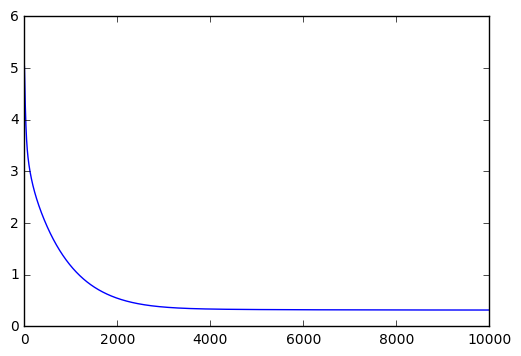

In [24]:
plt.plot(cost)
plt.show()

In [ ]:
np.matrix(train_features[0]).T

In [ ]:
cost[1500:1700]

In [34]:
f = None
if f != None: print(f)